Description

This project is to develop a machine learning model to predict the quality of wine based on its given features.
The prediction model will classify wines into different quality levels, which are rated on a scale from 3 to 8. 
It is a supervised learning problem, the project will try using different classifier model to rate the wine.

Goal

The goal of this project is to predict the wine quality and also try to see how different machine learning algorithm work on this dataset.


Dataset source

The dataset used for this analysis is the "Wine Quality" dataset available from the UCI Machine Learning Repository.
For this project, I cited the UCI online csv dataset: https://archive.ics.uci.edu/static/public/186/data.csv
The dataset can also be imported by installing ucimlrepo like below:
    pip install ucimlrepo
    from ucimlrepo import fetch_ucirepo 
  
    # fetch dataset 
    wine_quality = fetch_ucirepo(id=186) 

The link contains two datasets are related to red and white variants of the Portuguese Vinho Verde wine.




In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
%matplotlib inline
from sklearn.impute import SimpleImputer

#read data from UCI online dataset
wine = pd.read_csv('https://archive.ics.uci.edu/static/public/186/data.csv')
#Explorate the dataset
wine.head()
#Exploration
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Dataset description

From the exploration we can that the dataset includes 6497 rows,  1598 rows are red wine, 4898 rows are white wine.
We will perfom model selection based on Red Wine dataset.

Features
The dataset includes 13 features:

1.fixed_acidity: Tartaric acid content
2.volatile_acidity: Acetic acid content
3.citric_acid: Citric acid content
4.chlorides: Salt content
5.residual_sugar:Sugar content
6.free_sulfur_dioxide: Free form of SO2
7.total_sulfur_dioxide: Bound form of SO2
8.density: Density of the wine
9.pH: Acidity level
10.sulphates: Potassium sulphate content
11.alcohol: Alcohol content
12.quality: Quality score (target variable)
13.color:red or white

In [28]:
#Cleaning data

#remove null data
wine = wine.dropna()
# #remove duplicate data 
wine = wine.drop_duplicates()
#separate two dataset
red_wine=wine.loc[wine['color']=="red"]
red_wine=red_wine.drop(columns=['color'])
white_wine = wine.loc[wine['color']=="white"]
print(red_wine.shape)
# white_wine.info()

quality_counts = red_wine['quality'].value_counts()

print("Counts of each quality label:")
print(quality_counts)


(1359, 12)
Counts of each quality label:
quality
5    577
6    535
7    167
4     53
8     17
3     10
Name: count, dtype: int64


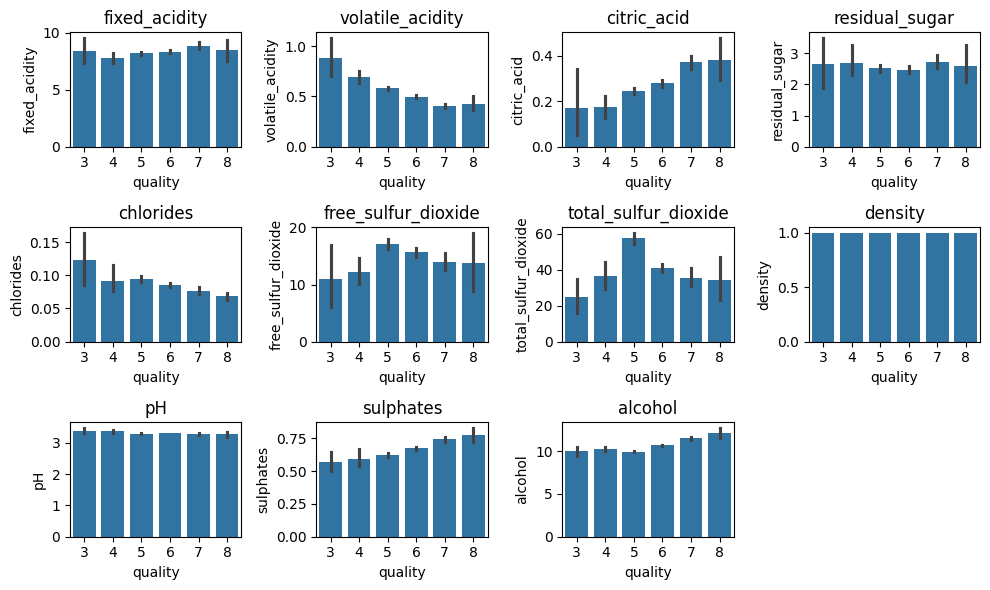

In [29]:
#To plot each feature's trend with quality 
# Column names
columns = red_wine.columns.drop('quality')

num_cols = 4
num_rows = (len(columns) - 1) // num_cols + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 2* num_rows))

for i, column in enumerate(columns):
    row = i // num_cols
    col = i % num_cols
    sns.barplot(x='quality', y=column, data=red_wine, ax=axes[row, col])
    axes[row, col].set_title(column)

for i in range(len(columns), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

#From the plot, we can see density has never change for different quality, so density has no affect for quality
#pH also has very few effect

This set of bar plots visualizes the distribution of various wine features across different quality ratings.

volatile_acidity and alcohol have clear trends that suggest a strong relationship with wine quality.
citric_acid and sulphates also show trends indicating they could be important factors in determining wine quality.
chlorides and total_sulfur_dioxide,free_sulfur_dioxide seem to be inversely related to wine quality, with higher quality wines having lower values.
fixed_acidity, residual_sugar, density, and pH show less pronounced trends and might have a lesser impact on the quality ratings or their impact might be more complex and not linear.

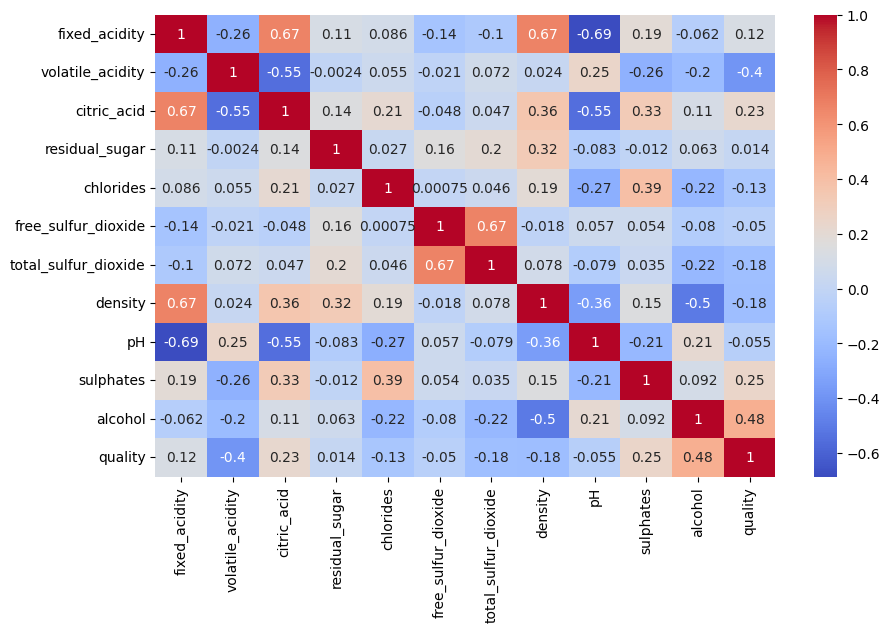

In [30]:
# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(red_wine.corr(), annot=True, cmap='coolwarm')
plt.show()

From the correlation matrix, we can see that
Below pairs of features have high positive correlations, 
meaning as one increases,the other tends to increase as well.
      density and residual_sugar (0.52)
      total_sulfur_dioxide and free_sulfur_dioxide (0.72)
      alcohol and quality (0.47)


In [31]:
red_wine=red_wine.drop(columns=['density'])

In [32]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
r_squared_values = []

# Iterate over each predictor and fit a simple linear regression model
for predictor in red_wine.columns:  
    # Fit the linear regression model
    if predictor!='quality':
        formula = f'quality ~ {predictor}'
        model = smf.ols(formula=formula, data=red_wine).fit()
    
    # Get the adjusted R-squared value and append it to the list
        r_squared_values.append((predictor, model.rsquared))

# Sort the predictors based on their adjusted R-squared values in descending order
sorted_predictors = sorted(r_squared_values, key=lambda x: x[1], reverse=True)
top_predictors = sorted_predictors[:5]
print(sorted_predictors)


[('alcohol', np.float64(0.23072929966053057)), ('volatile_acidity', np.float64(0.15619385998076674)), ('sulphates', np.float64(0.061918924698065925)), ('citric_acid', np.float64(0.05201020469644069)), ('total_sulfur_dioxide', np.float64(0.031632531101271844)), ('chlorides', np.float64(0.017157964305265616)), ('fixed_acidity', np.float64(0.014166632976074123)), ('pH', np.float64(0.0030520227267964994)), ('free_sulfur_dioxide', np.float64(0.0025464908336183534)), ('residual_sugar', np.float64(0.0001860624231431185))]


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from imblearn.combine import SMOTETomek


# Define features and target variable
X = red_wine.drop('quality', axis=1)
y = red_wine['quality']


# Create new features based on important features
for p in top_predictors:
    # Log transformation
    feature =p[0]
    # X[f'{feature}_log'] = np.log1p(red_wine[feature])
    
    # Polynomial features (squared)
    X[f'{feature}_squared'] = red_wine[feature] ** 2

    #Strong relation feature
    X['citric_acid_sulphates'] = red_wine['citric_acid']+red_wine['sulphates']
    X['alcohol_sulphates'] = red_wine['alcohol']+red_wine['sulphates']
    X['alcohol_citric_acid'] = red_wine['alcohol']+red_wine['citric_acid']



# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Split the data using stratified splitting to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [34]:
print(f'Shape of the X_train: {X_train.shape}')
print(f'Shape of the X_test: {X_test.shape}')
print(f'Shape of the y_train: {y_train.shape}')
print(f'Shape of the y_test: {y_test.shape}')

Shape of the X_train: (1087, 18)
Shape of the X_test: (272, 18)
Shape of the y_train: (1087,)
Shape of the y_test: (272,)


Shape of the X_train: (1087, 18)
Shape of the X_test: (272, 18)
Shape of the y_train: (1087,)
Shape of the y_test: (272,)

Results for Logistic Regression:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        11
           5       0.70      0.71      0.70       120
           6       0.55      0.65      0.60       103
           7       0.56      0.45      0.50        31
           8       0.00      0.00      0.00         3

    accuracy                           0.61       272
   macro avg       0.30      0.30      0.30       272
weighted avg       0.58      0.61      0.59       272

Cross-validation scores: [0.51470588 0.54411765 0.62132353 0.58823529 0.58302583]
Mean cross-validation score: 0.5702816366398957
Accuracy score of the Model: 
0.6102941176470589


<Figure size 800x600 with 0 Axes>

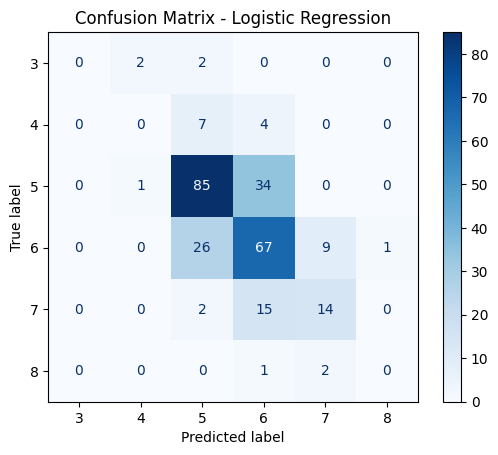

-
Results for Random Forest:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        11
           5       0.73      0.75      0.74       120
           6       0.58      0.70      0.63       103
           7       0.64      0.45      0.53        31
           8       0.00      0.00      0.00         3

    accuracy                           0.65       272
   macro avg       0.32      0.32      0.32       272
weighted avg       0.61      0.65      0.62       272

Cross-validation scores: [0.52205882 0.55514706 0.62132353 0.56985294 0.58302583]
Mean cross-validation score: 0.5702816366398958
Accuracy score of the Model: 
0.6470588235294118


<Figure size 800x600 with 0 Axes>

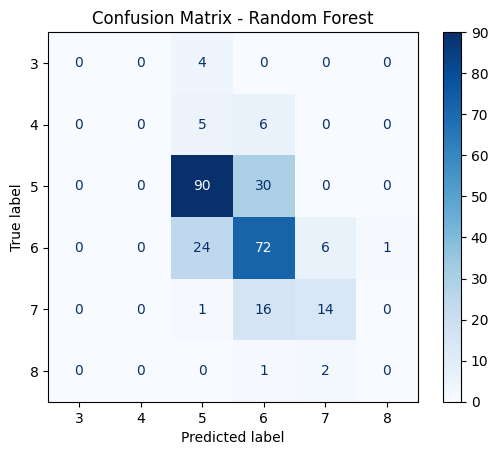

-
Results for Gradient Boosting:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        11
           5       0.69      0.65      0.67       120
           6       0.52      0.60      0.56       103
           7       0.64      0.58      0.61        31
           8       0.00      0.00      0.00         3

    accuracy                           0.58       272
   macro avg       0.31      0.31      0.31       272
weighted avg       0.58      0.58      0.58       272

Cross-validation scores: [0.54779412 0.54779412 0.58088235 0.57720588 0.56088561]
Mean cross-validation score: 0.5629124158888648
Accuracy score of the Model: 
0.5808823529411765


<Figure size 800x600 with 0 Axes>

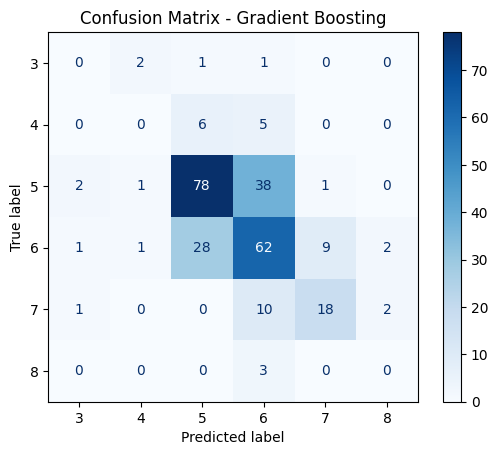

-
Results for AdaBoostClassifier:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.03      0.09      0.05        11
           5       0.64      0.53      0.58       120
           6       0.47      0.48      0.47       103
           7       0.30      0.35      0.32        31
           8       0.00      0.00      0.00         3

    accuracy                           0.46       272
   macro avg       0.24      0.24      0.24       272
weighted avg       0.49      0.46      0.47       272

Cross-validation scores: [0.51838235 0.52205882 0.60294118 0.54779412 0.53136531]
Mean cross-validation score: 0.5445083568482744
Accuracy score of the Model: 
0.45588235294117646


<Figure size 800x600 with 0 Axes>

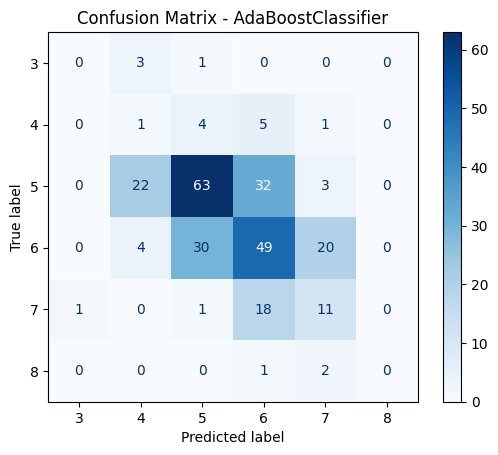

-
Results for KNN:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.18      0.18      0.18        11
           5       0.67      0.66      0.66       120
           6       0.50      0.52      0.51       103
           7       0.33      0.35      0.34        31
           8       0.00      0.00      0.00         3

    accuracy                           0.54       272
   macro avg       0.28      0.29      0.28       272
weighted avg       0.53      0.54      0.53       272

Cross-validation scores: [0.48161765 0.47058824 0.48161765 0.45955882 0.44280443]
Mean cross-validation score: 0.4672373561970914
Accuracy score of the Model: 
0.5367647058823529


<Figure size 800x600 with 0 Axes>

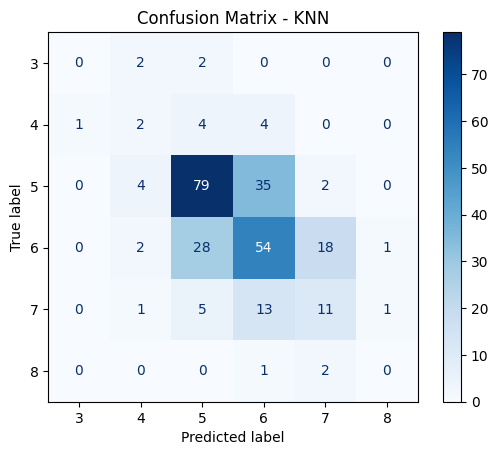

-
Results for Decision Tree:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.33      0.27      0.30        11
           5       0.65      0.61      0.63       120
           6       0.46      0.51      0.48       103
           7       0.48      0.45      0.47        31
           8       0.40      0.67      0.50         3

    accuracy                           0.53       272
   macro avg       0.39      0.42      0.40       272
weighted avg       0.53      0.53      0.53       272

Cross-validation scores: [0.48161765 0.41544118 0.48529412 0.44117647 0.43173432]
Mean cross-validation score: 0.45105274582157584
Accuracy score of the Model: 
0.5330882352941176


<Figure size 800x600 with 0 Axes>

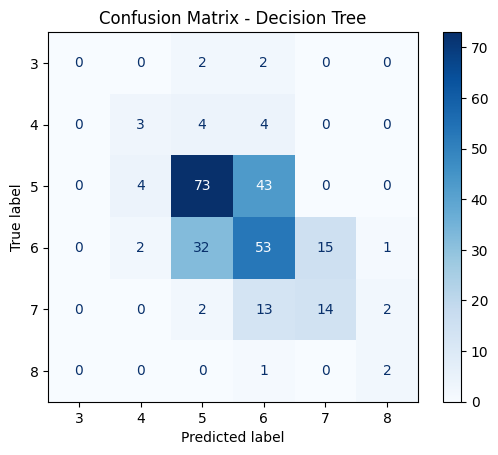

-


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'AdaBoostClassifier':AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0),
    'KNN':KNeighborsClassifier(n_neighbors=1),
    'Decision Tree':DecisionTreeClassifier(random_state=0)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Results for {name}:")
    print(classification_report(y_test, y_pred,zero_division=0))
    #print(confusion_matrix(y_test, y_pred))
    
    # Cross-validation
    scores = cross_val_score(model, X_scaled, y, cv=5)
    print(f"Cross-validation scores: {scores}")
    print(f"Mean cross-validation score: {scores.mean()}") 
    print("Accuracy score of the Model: \n{}".format(accuracy_score(y_test, y_pred)))

    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues, display_labels=["3", "4", "5", "6", "7", "8"])
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    print("-")
    




'''Conclusion
* Best Performing Model: Random Forest demonstrated the highest accuracy around 64-68%, although all models showed varying degrees
of challenges in predicting certain wine quality classes.

* Challenges: Models consistently struggled with predicting classes 3 (low quality) and 8 (high quality), 
meaning the data imbalance, we are lacking of data for 3 and 8.

* Cross-Validation Scores: The mean cross-validation scores generally reflected the model's overall performance, w
ith Random Forest showing a mean score of around 56%, slightly higher than other models.

* Improvement Strategies:
    * Feature Engineering: Explore additional features or interactions that better differentiate between wine qualities.
    * Model Tuning: Optimize hyperparameters to improve performance metrics like F1-score or balanced accuracy.
    * Ensemble Methods: Combine predictions from multiple models to potentially improve overall predictive power.
    * Data Augmentation: Increase the representation of minority classes (e.g., classes 3 and 8) through techniques like 
    synthetic data generation or oversampling.
    
In conclusion, while Random Forest showed the best performance among the models tested, 
I will choose Random Forest model for improvement, especially in accurately predicting extreme wine qualities (classes 3 and 8).
Future work should focus on refining feature selection, optimizing models, 
and addressing class imbalances to enhance predictive capabilities for wine quality assessment.

Best gama: 0.1
Best C: 1
Best accuracy: 0.5961019743795714
Results for SVM:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        11
           5       0.68      0.73      0.70       120
           6       0.58      0.69      0.63       103
           7       0.84      0.52      0.64        31
           8       0.00      0.00      0.00         3

    accuracy                           0.64       272
   macro avg       0.35      0.32      0.33       272
weighted avg       0.61      0.64      0.62       272

Cross-validation scores: [0.54779412 0.54779412 0.61764706 0.58455882 0.57933579]
Mean cross-validation score: 0.5754259822009985
Accuracy score of the Model: 
0.6433823529411765


<Figure size 800x600 with 0 Axes>

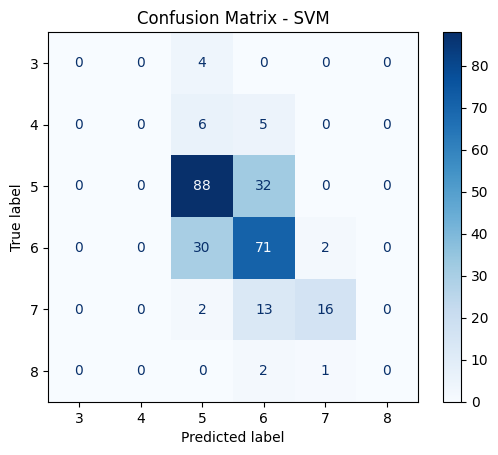

-


In [36]:
# using SVM model

nlsvm = SVC(C=1.0, kernel='rbf', gamma=1,probability=True, random_state=42)
nlsvm.fit(X_train,y_train)

# C tuning
# gamma tuning

param_grid = {'C': [0.1, 1, 5,8,10,15,20,100], 'gamma': [0.1, 1, 5,8,10,20,100]}

grid_search = GridSearchCV(nlsvm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best C value and the corresponding accuracy
best_C = grid_search.best_params_['C']
best_accuracy = grid_search.best_score_

best_gamma = grid_search.best_params_['gamma']

best_svm=grid_search.best_estimator_

print(f"Best gama: {best_gamma}")
print(f"Best C: {best_C}")
print(f"Best accuracy: {best_accuracy}")

best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)

print(f"Results for SVM:")
print(classification_report(y_test, y_pred,zero_division=0))
#print(confusion_matrix(y_test, y_pred))

# Cross-validation
scores = cross_val_score(best_svm, X_scaled, y, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}") 
print("Accuracy score of the Model: \n{}".format(accuracy_score(y_test, y_pred)))

# plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test, cmap=plt.cm.Blues, display_labels=["3", "4", "5", "6", "7", "8"])
plt.title(f"Confusion Matrix - SVM")
plt.show()
print("-")
    

SVM Result:

Best gama: 0.1
Best C: 1
Best accuracy: 0.5961019743795714
Results for SVM:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        11
           5       0.68      0.73      0.70       120
           6       0.58      0.69      0.63       103
           7       0.84      0.52      0.64        31
           8       0.00      0.00      0.00         3

    accuracy                           0.64       272
   macro avg       0.35      0.32      0.33       272
weighted avg       0.61      0.64      0.62       272

Cross-validation scores: [0.54779412 0.54779412 0.61764706 0.58455882 0.57933579]
Mean cross-validation score: 0.5754259822009985
Accuracy score of the Model: 
0.6433823529411765

In [14]:
# Define the parameter grid for GridSearchCV
rf_param_grid= {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the cross-validation strategy
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV
rf_grid_search = GridSearchCV(rf, param_grid=rf_param_grid, cv=kf, n_jobs=-1, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf = rf_grid_search.best_estimator_

# Evaluate the best estimator using cross-validation
cv_scores = cross_val_score(best_rf, X_scaled, y, cv=kf, scoring='accuracy')

print("Best parameters:", rf_grid_search.best_params_)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
print("Accuracy score of the best model on test set:", best_rf.score(X_test, y_test))

Best parameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 200}
Cross-validation scores: [0.56985294 0.60661765 0.55147059 0.5625     0.60885609]
Mean cross-validation score: 0.5798594530062947
Accuracy score of the best model on test set: 0.6507352941176471


Best parameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 200}
Cross-validation scores: [0.56985294 0.60661765 0.55147059 0.5625     0.60885609]
Mean cross-validation score: 0.5798594530062947
Accuracy score of the best model on test set: 0.6507352941176471

Cross-validation scores: [0.58455882 0.61029412 0.56985294 0.58455882 0.61623616]
Mean cross-validation score: 0.5931001736487953
Accuracy score of the Model: 
0.6507352941176471


<Figure size 800x600 with 0 Axes>

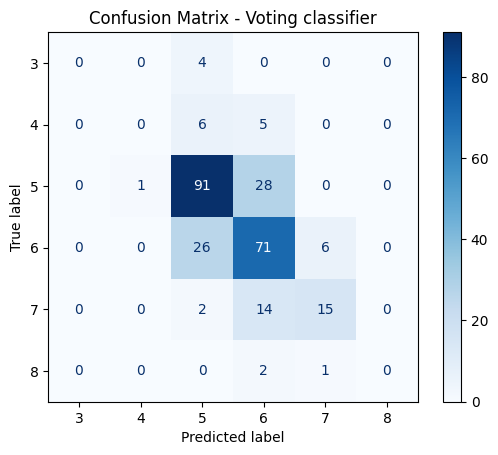

-


In [18]:
# Create the VotingClassifier
voting_clf = VotingClassifier(estimators=[('rf', best_rf), ('svm', best_svm)], voting='soft')

# Train the VotingClassifier
voting_clf.fit(X_train, y_train)

# Predict and evaluate the VotingClassifier on the test set
y_pred = voting_clf.predict(X_test)


# Evaluate the  ensemble using cross-validation
cv_scores = cross_val_score(voting_clf, X_scaled, y, cv=kf, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
print("Accuracy score of the Model: \n{}".format(accuracy_score(y_test, y_pred)))

# plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(voting_clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=["3", "4", "5", "6", "7", "8"])
plt.title(f"Confusion Matrix - Voting classifier")
plt.show()
print("-")


In [37]:

#Try duplicate data for 3/8
data_quality_3 = red_wine[red_wine['quality'] == 3]
data_quality_8 = red_wine[red_wine['quality'] == 8]
data_quality_4 = red_wine[red_wine['quality'] == 4]
# Number of times to duplicate
n_duplicates =2  # Change this value as needed

# Duplicate the data
data_quality_3_duplicated = pd.concat([data_quality_3] * n_duplicates, ignore_index=True)
data_quality_8_duplicated = pd.concat([data_quality_8] * n_duplicates, ignore_index=True)
data_quality_4_duplicated = pd.concat([data_quality_4] * n_duplicates, ignore_index=True)
# Combine the duplicated data with the original data
data_balanced = pd.concat([red_wine, data_quality_3_duplicated, data_quality_8_duplicated,data_quality_4_duplicated], ignore_index=True)
print(data_balanced.shape)
# Shuffle the dataset
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
quality_counts = data_balanced['quality'].value_counts()

print("Counts of each quality label:")
print(quality_counts)

# Split the data into features and target
X = data_balanced.drop(columns='quality')
y = data_balanced['quality']



# Create new features based on important features
#Tried different features, Polynomial features are better to use 
for p in top_predictors:
#     # Log transformation
    feature =p[0]
    #X[f'{feature}_log'] = np.log1p(red_wine[feature])
    
    #Polynomial features (squared)
    # X[f'{feature}_squared'] = red_wine[feature] ** 2

    #Strong relation feature
    #X['citric_acid_sulphates'] = red_wine['citric_acid']+red_wine['sulphates']
    #X['alcohol_sulphates'] = red_wine['alcohol']+red_wine['sulphates']
    #X['alcohol_citric_acid'] = red_wine['alcohol']+red_wine['citric_acid']
    
# #     # Interaction features
#     for x in top_predictors:
#         other_feature =x[0]
#         if feature != other_feature:
#             X[f'{feature}_{other_feature}_interaction'] = red_wine[feature] * red_wine[other_feature]
  



# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_imputed = imputer.fit_transform(X)

print(X_imputed.shape)

#Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)



# Split the data using stratified splitting to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
# # Split into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



# Train and evaluate Random Forest
model = RandomForestClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Results for Random Forest:")
print(classification_report(y_test, y_pred,zero_division=0))
#print(confusion_matrix(y_test, y_pred))

# Cross-validation
scores = cross_val_score(model, X_scaled, y, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}") 
print("Accuracy score of the Model: \n{}".format(accuracy_score(y_test, y_pred)))
print("-")
    



(1519, 11)
Counts of each quality label:
quality
5    577
6    535
7    167
4    159
8     51
3     30
Name: count, dtype: int64
(1519, 10)
Results for Random Forest:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         7
           4       0.83      0.89      0.86        54
           5       0.77      0.67      0.72       184
           6       0.57      0.73      0.64       154
           7       0.55      0.25      0.34        48
           8       0.90      1.00      0.95         9

    accuracy                           0.68       456
   macro avg       0.77      0.76      0.75       456
weighted avg       0.69      0.68      0.68       456

Cross-validation scores: [0.70394737 0.69078947 0.71381579 0.68092105 0.69966997]
Mean cross-validation score: 0.6978287302414452
Accuracy score of the Model: 
0.6842105263157895
-


Cross-validation scores: [0.58455882 0.61029412 0.56985294 0.58455882 0.61623616]
Mean cross-validation score: 0.5931001736487953
Accuracy score of the Model: 
0.6507352941176471


Output:

(1519, 11)
Counts of each quality label:
quality
5    577
6    535
7    167
4    159
8     51
3     30
Name: count, dtype: int64
(1519, 10)
Results for Random Forest:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         7
           4       0.84      0.89      0.86        54
           5       0.75      0.66      0.71       184
           6       0.56      0.73      0.63       154
           7       0.60      0.25      0.35        48
           8       0.90      1.00      0.95         9

    accuracy                           0.68       456
   macro avg       0.78      0.75      0.75       456
weighted avg       0.69      0.68      0.67       456

Cross-validation scores: [0.70394737 0.71052632 0.70723684 0.69407895 0.72607261]
Mean cross-validation score: 0.7083724161889873
Accuracy score of the Model: 
0.6798245614035088

Best gama: 1
Best C: 5
Best accuracy: 0.6105102311985118
Results for SVM:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         7
           4       0.94      0.89      0.91        54
           5       0.69      0.68      0.68       184
           6       0.53      0.63      0.58       154
           7       0.46      0.23      0.31        48
           8       0.90      1.00      0.95         9

    accuracy                           0.65       456
   macro avg       0.75      0.74      0.74       456
weighted avg       0.65      0.65      0.65       456

Cross-validation scores: [0.65460526 0.63815789 0.66118421 0.64473684 0.65016502]
Mean cross-validation score: 0.6497698454055932
Accuracy score of the Model: 
0.6513157894736842


<Figure size 800x600 with 0 Axes>

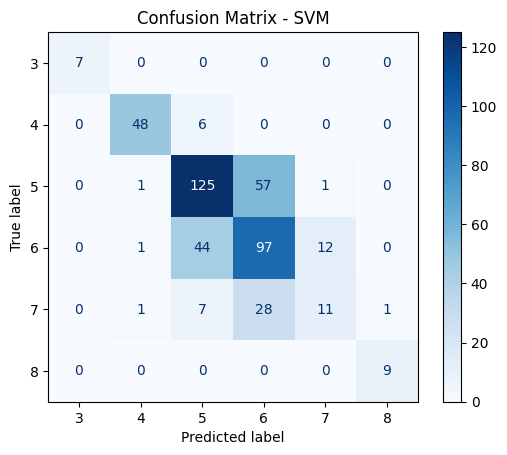

-


In [38]:
# after duplicate data , using SVM model

nlsvm = SVC(C=1.0, kernel='rbf', gamma=1,probability=True, random_state=42)
nlsvm.fit(X_train,y_train)

# C tuning
# gamma tuning

param_grid = {'C': [0.1, 1, 5,8,10,15,20,100], 'gamma': [0.1, 1, 5,8,10,20,100]}

grid_search = GridSearchCV(nlsvm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best C value and the corresponding accuracy
best_C = grid_search.best_params_['C']
best_accuracy = grid_search.best_score_

best_gamma = grid_search.best_params_['gamma']

best_svm=grid_search.best_estimator_

print(f"Best gama: {best_gamma}")
print(f"Best C: {best_C}")
print(f"Best accuracy: {best_accuracy}")

best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)

print(f"Results for SVM:")
print(classification_report(y_test, y_pred,zero_division=0))
#print(confusion_matrix(y_test, y_pred))

# Cross-validation
scores = cross_val_score(best_svm, X_scaled, y, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}") 
print("Accuracy score of the Model: \n{}".format(accuracy_score(y_test, y_pred)))

# plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test, cmap=plt.cm.Blues, display_labels=["3", "4", "5", "6", "7", "8"])
plt.title(f"Confusion Matrix - SVM")
plt.show()
print("-")
    

In [39]:
# using rf model again 
#Define the parameter grid for GridSearchCV
rf_param_grid= {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the cross-validation strategy
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV
rf_grid_search = GridSearchCV(rf, param_grid=rf_param_grid, cv=kf, n_jobs=-1, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf = rf_grid_search.best_estimator_

# Evaluate the best estimator using cross-validation
cv_scores = cross_val_score(best_rf, X_scaled, y, cv=kf, scoring='accuracy')

print("Best parameters:", rf_grid_search.best_params_)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
print("Accuracy score of the best model on test set:", best_rf.score(X_test, y_test))


Best parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 50}
Cross-validation scores: [0.64144737 0.625      0.67434211 0.60526316 0.72937294]
Mean cross-validation score: 0.6550851137745354
Accuracy score of the best model on test set: 0.6578947368421053


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Results for Gradient Boosting:
              precision    recall  f1-score   support

           3       0.78      1.00      0.88         7
           4       0.85      0.85      0.85        54
           5       0.71      0.65      0.68       184
           6       0.53      0.62      0.57       154
           7       0.44      0.29      0.35        48
           8       0.90      1.00      0.95         9

    accuracy                           0.64       456
   macro avg       0.70      0.74      0.71       456
weighted avg       0.64      0.64      0.64       456

Cross-validation scores: [0.59868421 0.64802632 0.65460526 0.625      0.69966997]
Mean cross-validation score: 0.6451971512940767
Accuracy score of the Model: 
0.6403508771929824


<Figure size 800x600 with 0 Axes>

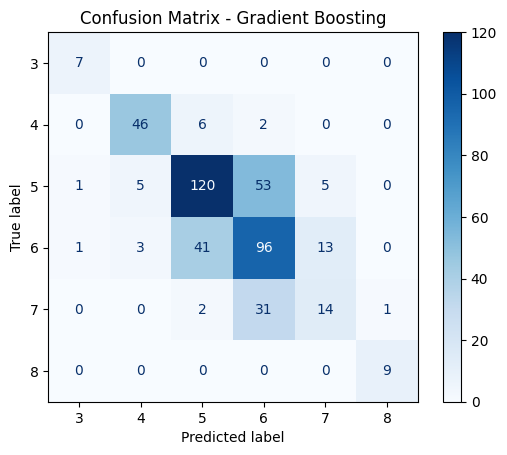

-
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   2.0s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=   3.1s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=   3.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   1.8s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.8s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   3.6s
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=   5.6s
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=   1.7s
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time=   3.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.9s
[CV] END ..learning_rate=0

In [40]:
#Try graident boosting 
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
# lgbm = LGBMClassifier(random_state=42)

# Hyperparameter tuning using Grid Search for the best model
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_gb = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

y_pred = best_gb.predict(X_test)
print(f"Results for Gradient Boosting:")
print(classification_report(y_test, y_pred, zero_division=0))
# Evaluate the  ensemble using cross-validation
cv_scores = cross_val_score(best_gb, X_scaled, y, cv=kf, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
print("Accuracy score of the Model: \n{}".format(accuracy_score(y_test, y_pred)))

# plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_gb, X_test, y_test, cmap=plt.cm.Blues, display_labels=["3", "4", "5", "6", "7", "8"])
plt.title(f"Confusion Matrix - Gradient Boosting")
plt.show()
print("-")

Output for gradient boosting
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Results for Gradient Boosting:
              precision    recall  f1-score   support

           3       0.78      1.00      0.88         7
           4       0.85      0.85      0.85        54
           5       0.71      0.65      0.68       184
           6       0.53      0.62      0.57       154
           7       0.44      0.29      0.35        48
           8       0.90      1.00      0.95         9

    accuracy                           0.64       456
   macro avg       0.70      0.74      0.71       456
weighted avg       0.64      0.64      0.64       456

Cross-validation scores: [0.59868421 0.64802632 0.65460526 0.625      0.69966997]
Mean cross-validation score: 0.6451971512940767
Accuracy score of the Model: 
0.6403508771929824

Cross-validation scores: [0.63486842 0.64473684 0.70065789 0.64473684 0.70957096]
Mean cross-validation score: 0.6669141914191419
Accuracy score of the Model: 
0.6666666666666666


<Figure size 800x600 with 0 Axes>

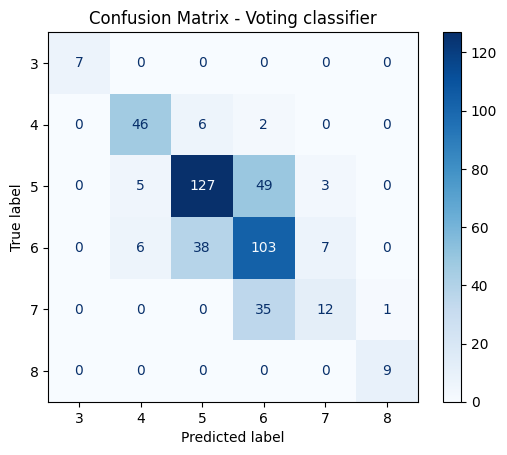

-


In [22]:
# Create the VotingClassifier for 3 models 
voting_clf = VotingClassifier(estimators=[('rf', best_rf), ('svm', best_svm),('gb',best_gb)], voting='soft')

# Train the VotingClassifier
voting_clf.fit(X_train, y_train)

# Predict and evaluate the VotingClassifier on the test set
y_pred = voting_clf.predict(X_test)


# Evaluate the  ensemble using cross-validation
cv_scores = cross_val_score(voting_clf, X_scaled, y, cv=kf, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
print("Accuracy score of the Model: \n{}".format(accuracy_score(y_test, y_pred)))

# plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(voting_clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=["3", "4", "5", "6", "7", "8"])
plt.title(f"Confusion Matrix - Voting classifier")
plt.show()
print("-")


After duplicate data for 3/4/8, the simple model Random forest without any feature engineering has the best performance.(68%)
The model tuning result for Random Forest/SVM/Gradient boosting and combine them together doesn't perform well as expected.
This is because duplicate data already bring in the possibility of overfitting, parameter tuning and feature enginerring cannot solve it.

In [26]:
# Other exploration test. 
# Try update quality as 0/1/2
# Let's say quality 3-4 is Low
# 5-6 is normal
# quality 7-8 is good

other_red_wine=wine.loc[wine['color']=='red']
other_red_wine=other_red_wine.drop(columns=['color'])
# Update quality to four categories
def categorize_quality(quality):
    if quality <= 4:
        return 0  # Low quality
    elif quality <= 6: 
        return 1  # Medium quality
    else:
        return 2  # High quality


other_red_wine.loc[:, 'quality'] = other_red_wine['quality'].apply(categorize_quality)

# Define features and target variable
X_new = other_red_wine.drop('quality', axis=1)
y_new = other_red_wine['quality']


# Create new features based on important features
for p in top_predictors:
    # Log transformation
    feature =p[0]
    #X[f'{feature}_log'] = np.log1p(other_red_wine[feature])
    
    # Polynomial features (squared)
    X_new[f'{feature}_squared'] = other_red_wine[feature] ** 2
    
    #Strong relation feature
    X_new['citric_acid_sulphates'] = other_red_wine['citric_acid']+other_red_wine['sulphates']
    X_new['alcohol_sulphates'] = other_red_wine['alcohol']+other_red_wine['sulphates']
    X_new['alcohol_citric_acid'] = other_red_wine['alcohol']+other_red_wine['citric_acid']


# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_new_imputed = imputer.fit_transform(X_new)

# Normalize the features
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new_imputed)


# Balance the dataset using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_new_balanced, y_new_balanced = smote.fit_resample(X_scaled, y)

# Split the data using stratified splitting to maintain class distribution
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new_balanced, y_new_balanced, test_size=0.2, random_state=42)


# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'AdaBoostClassifier':AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0),
    'KNN':KNeighborsClassifier(n_neighbors=1),
    'Decision Tree':DecisionTreeClassifier(random_state=0)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_new_train, y_new_train)
    y_new_pred = model.predict(X_new_test)
    print(f"Results for {name}:")
    print(classification_report(y_new_test, y_new_pred,zero_division=0))
    #print(confusion_matrix(y_test, y_pred))
    
    # Cross-validation
    scores = cross_val_score(model, X_new_scaled, y_new, cv=5)
    print(f"Cross-validation scores: {scores}")
    print(f"Mean cross-validation score: {scores.mean()}") 
    print("Accuracy score of the Model: \n{}".format(accuracy_score(y_new_test, y_new_pred)))
    print("-")
    


Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       222
           1       0.65      0.59      0.62       240
           2       0.77      0.84      0.80       206

    accuracy                           0.72       668
   macro avg       0.72      0.72      0.72       668
weighted avg       0.71      0.72      0.71       668

Cross-validation scores: [0.82352941 0.81985294 0.83823529 0.8125     0.84870849]
Mean cross-validation score: 0.8285652268287389
Accuracy score of the Model: 
0.7170658682634731
-
Results for Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       222
           1       0.93      0.79      0.86       240
           2       0.85      0.97      0.91       206

    accuracy                           0.90       668
   macro avg       0.91      0.91      0.90       668
weighted avg       0.91      0.90      0.90       66

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       222
           1       0.65      0.59      0.62       240
           2       0.77      0.84      0.80       206

    accuracy                           0.72       668
   macro avg       0.72      0.72      0.72       668
weighted avg       0.71      0.72      0.71       668

Cross-validation scores: [0.82352941 0.81985294 0.83823529 0.8125     0.84870849]
Mean cross-validation score: 0.8285652268287389
Accuracy score of the Model: 
0.7170658682634731
-
Results for Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       222
           1       0.93      0.79      0.86       240
           2       0.85      0.97      0.91       206

    accuracy                           0.90       668
   macro avg       0.91      0.91      0.90       668
weighted avg       0.91      0.90      0.90       668

Cross-validation scores: [0.82720588 0.79411765 0.83455882 0.81617647 0.8302583 ]
Mean cross-validation score: 0.8204634252224874
Accuracy score of the Model: 
0.9041916167664671
-
Results for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       222
           1       0.87      0.80      0.84       240
           2       0.86      0.91      0.88       206

    accuracy                           0.88       668
   macro avg       0.88      0.89      0.89       668
weighted avg       0.88      0.88      0.88       668

Cross-validation scores: [0.80514706 0.80147059 0.82352941 0.79044118 0.83763838]
Mean cross-validation score: 0.8116453223355762
Accuracy score of the Model: 
0.8847305389221557
-
Results for AdaBoostClassifier:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       222
           1       0.62      0.56      0.59       240
           2       0.80      0.72      0.76       206

    accuracy                           0.70       668
   macro avg       0.70      0.70      0.70       668
weighted avg       0.70      0.70      0.69       668

Cross-validation scores: [0.73161765 0.79779412 0.83088235 0.76838235 0.78597786]
Mean cross-validation score: 0.7829308660733666
Accuracy score of the Model: 
0.6961077844311377
-
Results for KNN:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       222
           1       0.98      0.74      0.85       240
           2       0.85      1.00      0.92       206

    accuracy                           0.90       668
   macro avg       0.91      0.91      0.90       668
weighted avg       0.91      0.90      0.90       668

Cross-validation scores: [0.79411765 0.70588235 0.78308824 0.73161765 0.75276753]
Mean cross-validation score: 0.7534946820056436
Accuracy score of the Model: 
0.9026946107784432
-
Results for Decision Tree:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       222
           1       0.77      0.76      0.77       240
           2       0.85      0.87      0.86       206

    accuracy                           0.83       668
   macro avg       0.83      0.83      0.83       668
weighted avg       0.83      0.83      0.83       668

Cross-validation scores: [0.78676471 0.73897059 0.70955882 0.67647059 0.70479705]
Mean cross-validation score: 0.7233123507705665
Accuracy score of the Model: 
0.8293413173652695

In [27]:
# Define the parameter grid for GridSearchCV
rf_param_grid= {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the cross-validation strategy
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV
rf_grid_search = GridSearchCV(rf, param_grid=rf_param_grid, cv=kf, n_jobs=-1, scoring='accuracy')
rf_grid_search.fit(X_new_train, y_new_train)

# Get the best estimator
best_rf = rf_grid_search.best_estimator_

# Evaluate the best estimator using cross-validation
cv_scores = cross_val_score(best_rf, X_new_train, y_new_train, cv=kf, scoring='accuracy')

print("Best parameters:", rf_grid_search.best_params_)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
print("Accuracy score of the best model on test set:", best_rf.score(X_new_test, y_new_test))


Best parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Cross-validation scores: [0.93258427 0.93445693 0.91947566 0.93433396 0.91557223]
Mean cross-validation score: 0.9272846090604381
Accuracy score of the best model on test set: 0.9116766467065869


Summary of Results
In our analysis of the wine quality dataset, we compared several machine learning models to predict wine quality based on various chemical properties. The models we tested included Logistic Regression, Random Forest, Gradient Boosting, AdaBoost, K-Nearest Neighbors, Decision Tree, and a combination of Random Forest and Support Vector Machine (SVM) through a Voting Classifier.


Model Performance
The Random Forest model performed the best among individual models, with an accuracy of about 65%. The Voting Classifier, which combined Random Forest and SVM, also achieved an accuracy of about 65%.

After applying data augmentation, the accuracy of a simple Random Forest achieved an accuracy of about 68%, but adding more features makes the performance worse. That could be the data augmentation bring in overfitting.

Change the quality rating from 3-8 to 0-2(reduce 6 category to 3 category) will highly improve the model accuracy(random forest acchieved an accuracy of 90%), because most of the poor performance is caused by the limited dataset for rating 3 and rating 8. If we can have more data entries for rating 3/8, the parameter tuning and model combine will bring more significant improvement.

Here are some key points:
* Random Forest: Performed well overall but struggled with predicting the quality of wines with fewer samples.
* SVM: Needed careful tuning of settings to perform well. When combined with Random Forest, it helped improve the overall accuracy.
* Voting Classifier: This ensemble method performed the best stable result, showing the advantage of combining different models.

Insights from Feature Analysis
We also looked at how different chemical properties relate to wine quality. Some key insights include:
* Alcohol: Higher alcohol content generally means better quality wine.
* Sulphates: Higher levels of sulphates are linked to better quality.
* Volatile Acidity: Lower volatile acidity is a sign of higher quality wine.
* Chlorides: Lower chloride levels tend to be found in higher quality wines.
    
Challenges and Learnings
1. Data Imbalance: The dataset had more samples of some wine qualities than others. For example quality 3 has  10  rows and quality 8 has only 17 rows. This made it hard to predict the less common wine qualities accurately.
2. Feature Interaction and Collinearity: Some models can be affected by how features interact with each other or if they are highly correlated. Random Forest handled this slightly better than others.
3. Hyper-parameter Tuning: Finding the best settings for each model was time-consuming but necessary for good performance.
4. Overfitting: Adding more duplicate data and interaction features can also bring overfitting.
   
Future Work
1. Advanced Ensemble Methods: Trying more advanced combinations of models, like Stacking or using models like XGBoost, could be helpful. 
2. Data Augmentation: Creating more data samples for less common wine qualities could help address the imbalance problem

